In [1]:
import numpy as np
import pandas as pd
from scipy.stats import mannwhitneyu
from scipy import stats
import random
from numpy.random import normal as norm
import matplotlib.pyplot as plt
import seaborn as sns

from general_class_balancer import *

## Test Leming example

In [2]:
# Sample script showing how this balances on simulated, random data.
show_balanced = True
N = int(12000) # Number of datapoints
confounds = np.random.rand(2, N)

In [3]:
confounds.shape

(2, 12000)

In [4]:
# Unfortunately, numpy arrays don't support mixed types, so in order to mix
# floats (i.e., continuous covariates) and strings (i.e., discrete, or labeled,
# covariates), it is necessary to cast them all as objects. Slows things down,
# but if covariates are all of one type, they can be cast as one or the other.
c1 = np.array([norm(1, 2, int(N/3)),norm(0.5, 2, int(N/3)),norm(2, 1, int(N/3))],dtype=object)
c2 = np.array([norm(3, 2, int(N/3)),norm(0.5, 2, int(N/3)),norm(3.1, 0.25, int(N/3))],dtype=object)
c3 = np.array([norm(2, 1, int(N/3)),norm(0.5, 2, int(N/3)),norm(2.9, 1, int(N/3))],dtype=object)
confounds = np.concatenate((c1,c2,c3),axis=1)
c4 = np.array([[np.random.choice(["a","b","c"]) for x in range(N)]],dtype=object)
confounds = np.concatenate((confounds,c4),axis=0)

In [5]:
print(confounds.shape)

(4, 12000)


In [6]:
classes = np.array([0 for x in range(int(N/2))] + [1 for x in range(int(N/2))])
classes = np.array([0 for x in range(int(N/3))] + [1 for x in range(int(N/3))] + [2 for x in range(int(N/3))])

print(classes.shape)
classes

(12000,)


array([0, 0, 0, ..., 2, 2, 2])

In [7]:
selection = class_balance(classes,confounds,plim=0.25)
print(np.sum(selection))

3150


In [8]:
print(test_all(classes[selection],confounds[:,selection]))

0.0786961055104515


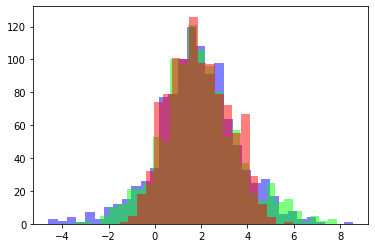

In [9]:
cnum = 0
no_bins = 50
#bins = (np.array(range(no_bins)) - (no_bins/2))/(float(no_bins)/4)
bins = 'auto'
if show_balanced:
	plt.hist(confounds[cnum,np.logical_and(selection,classes == 0)], bins= bins, fc=(0, 0, 1, 0.5))
	plt.hist(confounds[cnum,np.logical_and(selection,classes == 1)], bins= bins, fc=(0, 1, 0, 0.5))
	plt.hist(confounds[cnum,np.logical_and(selection,classes == 2)], bins= bins, fc=(1, 0, 0, 0.5))
else:
	plt.hist(confounds[cnum,classes == 0], bins= bins)
	plt.hist(confounds[cnum,classes == 1], bins= bins)
	plt.hist(confounds[cnum,classes == 2], bins= bins)


plt.show()

## SZ Data
#### Load & format data

In [10]:
p_pheno = '/home/harveyaa/Documents/fMRI/data/ukbb_9cohorts/pheno_26-01-22.csv'
p_conn = '/home/harveyaa/Documents/fMRI/data/ukbb_9cohorts/connectomes_01-12-21.csv'

pheno = pd.read_csv(p_pheno,index_col=0)
conn = pd.read_csv(p_conn,index_col=0)

/home/harveyaa/miniconda3/envs/MTL/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3457: DtypeWarning: Columns (7,8,12,13,14,19,20,24,27,31,42,43,44,49,51,59,60,62,64,65,68,101,121,163) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [11]:
pheno_con_sz = pheno[(pheno['CON_IPC'] == 1)&(pheno['PI'].isin(pheno[pheno['SZ'] == 1]['PI'].unique()))]
pheno_sz = pd.concat([pheno_con_sz,pheno[pheno['SZ']==1]])
pheno_sz.loc[:,'SZ'] = pheno_sz.loc[:,'SZ'].astype(int)

#### Generate balanced subset

In [12]:
conf = ['AGE','SEX','SITE','mean_conn','FD_scrubbed']

confounds_sz = pheno_sz[conf].transpose().values
classes_sz = pheno_sz['SZ'].values

selection_sz = class_balance(classes_sz,confounds_sz,plim=0.25)

#### Plot

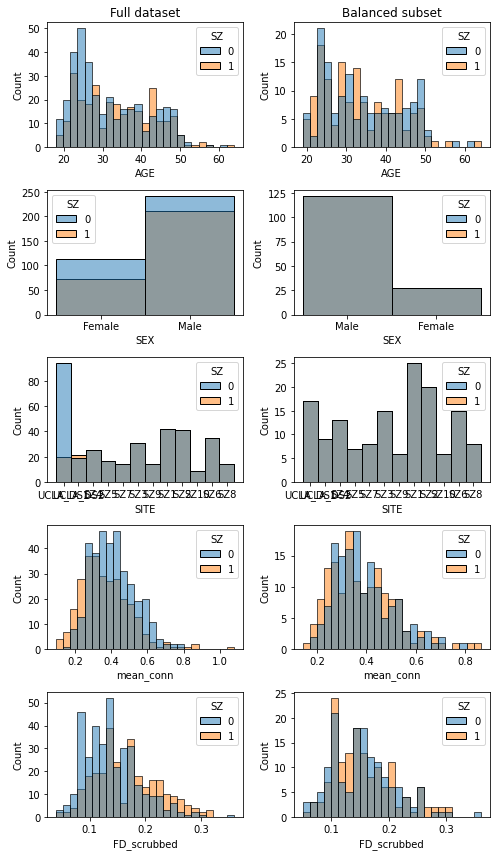

In [13]:
fig, ax = plt.subplots(len(conf),2,figsize=(7,12))

for i,c in enumerate(conf):
    sns.histplot(x=c,data=pheno_sz,hue='SZ',bins=25,ax=ax[i,0])
    sns.histplot(x=c,data=pheno_sz[selection_sz],hue='SZ',bins=25,ax=ax[i,1])

    if i == 0:
        ax[i,0].set_title('Full dataset')
        ax[i,1].set_title('Balanced subset')

plt.tight_layout()

In [14]:
print(np.sum(selection_sz))

pheno_sz.shape[0]

298


638

#### Test prediction

In [15]:
# X confounds array
# y labels

X = pd.get_dummies(pheno_sz[conf],columns=['SEX','SITE'],drop_first=True)
y = pheno_sz['SZ']

In [16]:
# Test set: balanced
# Train set: rest

X_train = X[~selection_sz]
X_test = X[selection_sz]
y_train = y[~selection_sz]
y_test = y[selection_sz]

In [17]:
print('Chance level: ', np.sum(y_test)/len(y_test))

Chance level:  0.5


In [18]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

clf = SVC()

In [19]:
clf.fit(X_train,y_train)
pred = clf.predict(X_test)
acc = accuracy_score(y_test,pred)
print('Accuracy w/ conf: ', acc)

Accuracy w/ conf:  0.47651006711409394


In [20]:
X_conn = conn[conn.index.isin(pheno_sz.index)]

X_conn_train = X_conn[~selection_sz]
X_conn_test = X_conn[selection_sz]

In [21]:
clf.fit(X_conn_train,y_train)
pred = clf.predict(X_conn_test)
acc = accuracy_score(y_test,pred)
print('Accuracy w/ conn: ', acc)

Accuracy w/ conn:  0.7114093959731543


#### Compare w/ random split

In [22]:
from sklearn.model_selection import train_test_split

X_train_rand,X_test_rand, y_train_rand, y_test_rand = train_test_split(pheno_sz.index,y)
rand_train_mask = pheno_sz.index.isin(X_train_rand)

print('Chance level: ',np.sum(y[~rand_train_mask])/len(y[~rand_train_mask]))

Chance level:  0.48125


In [23]:
clf.fit(X[rand_train_mask],y[rand_train_mask])
pred = clf.predict(X[~rand_train_mask])
print('Accuracy w/ conf rand split: ',accuracy_score(y[~rand_train_mask],pred))

Accuracy w/ conf rand split:  0.51875


In [24]:
clf.fit(X_conn[rand_train_mask],y[rand_train_mask])
pred = clf.predict(X_conn[~rand_train_mask])
print('Accuracy w/ conn rand split: ',accuracy_score(y[~rand_train_mask],pred))

Accuracy w/ conn rand split:  0.79375


#### Are balanced subsets different from each other?

In [32]:
selections = []
for i in range(5):
    selection_sz = class_balance(classes_sz,confounds_sz,plim=0.25)
    idx = pheno_sz[selection_sz].index
    selections.append(idx)
    print(len(idx))

300
350
298
344
302


In [36]:
from itertools import combinations

for i,j in combinations(list(range(5)),2):
    intersect = set(selections[i]).intersection(selections[j])
    print(len(selections[i]))
    print(len(selections[j]))
    print('overlap: ', len(intersect))
    print()

300
350
overlap:  254

300
298
overlap:  258

300
344
overlap:  238

300
302
overlap:  262

350
298
overlap:  243

350
344
overlap:  269

350
302
overlap:  248

298
344
overlap:  234

298
302
overlap:  262

344
302
overlap:  246



## UKBB CNVs

In [40]:
pis = pheno[pheno['DEL1q21_1']==1]['PI'].unique()
pheno_cnv = pheno[pheno['PI'].isin(pis)]

In [50]:
confounds_cnv = pheno_cnv[conf].transpose().values
classes_cnv = pheno_cnv['DEL1q21_1'].values.astype(int)

In [53]:
selection_cnv = class_balance(classes_cnv,confounds_cnv,plim=0.25)

In [54]:
np.sum(selection_cnv)

50

#### try subset of balanced

In [57]:
pheno_cnv2 = pheno_cnv[selection_cnv]

In [58]:
confounds_cnv2 = pheno_cnv2[conf].transpose().values
classes_cnv2 = pheno_cnv2['DEL1q21_1'].values.astype(int)

selection_cnv2 = class_balance(classes_cnv2,confounds_cnv2,plim=0.25)
np.sum(selection_cnv2)

36

#### Plot

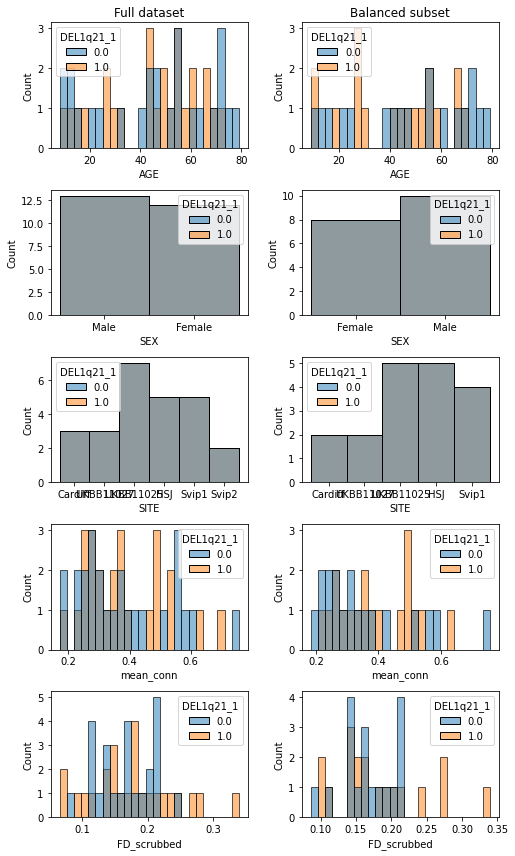

In [59]:
fig, ax = plt.subplots(len(conf),2,figsize=(7,12))

for i,c in enumerate(conf):
    sns.histplot(x=c,data=pheno_cnv2,hue='DEL1q21_1',bins=25,ax=ax[i,0])
    sns.histplot(x=c,data=pheno_cnv2[selection_cnv2],hue='DEL1q21_1',bins=25,ax=ax[i,1])

    if i == 0:
        ax[i,0].set_title('Full dataset')
        ax[i,1].set_title('Balanced subset')

plt.tight_layout()

#### Test prediction

In [60]:
# X confounds array
# y labels

X = pd.get_dummies(pheno_cnv2[conf],columns=['SEX','SITE'],drop_first=True)
y = pheno_cnv2['DEL1q21_1']

In [62]:
# Test set: balanced
# Train set: rest

X_train = X[~selection_cnv2]
X_test = X[selection_cnv2]
y_train = y[~selection_cnv2]
y_test = y[selection_cnv2]

In [63]:
print('Chance level: ', np.sum(y_test)/len(y_test))

Chance level:  0.5


In [64]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

clf = SVC()

In [65]:
clf.fit(X_train,y_train)
pred = clf.predict(X_test)
acc = accuracy_score(y_test,pred)
print('Accuracy w/ conf: ', acc)

Accuracy w/ conf:  0.4722222222222222


In [70]:
X_conn = conn[conn.index.isin(pheno_cnv2.index)]

X_conn_train = X_conn[~selection_cnv2]
X_conn_test = X_conn[selection_cnv2]

In [71]:
clf.fit(X_conn_train,y_train)
pred = clf.predict(X_conn_test)
acc = accuracy_score(y_test,pred)
print('Accuracy w/ conn: ', acc)

Accuracy w/ conn:  0.3888888888888889


#### Compare w/ random split

In [73]:
from sklearn.model_selection import train_test_split

X_train_rand,X_test_rand, y_train_rand, y_test_rand = train_test_split(pheno_cnv2.index,y)
rand_train_mask = pheno_cnv2.index.isin(X_train_rand)

print('Chance level: ',np.sum(y[~rand_train_mask])/len(y[~rand_train_mask]))

Chance level:  0.46153846153846156


In [74]:
clf.fit(X[rand_train_mask],y[rand_train_mask])
pred = clf.predict(X[~rand_train_mask])
print('Accuracy w/ conf rand split: ',accuracy_score(y[~rand_train_mask],pred))

Accuracy w/ conf rand split:  0.46153846153846156


In [75]:
clf.fit(X_conn[rand_train_mask],y[rand_train_mask])
pred = clf.predict(X_conn[~rand_train_mask])
print('Accuracy w/ conn rand split: ',accuracy_score(y[~rand_train_mask],pred))

Accuracy w/ conn rand split:  0.38461538461538464
